# Solving a Lid-Driven Cavity Flow with Scalar Mixing

_Highlights_
- solving the two-dimensional incompressible Navier-Stokes equations with a vorticity-streamfunction method
- solving a scalar transport equation with slope limiters
- using Spitfire `odesolve` to solve this problem with the Forward Euler method and a fourth-order method using adaptive time-stepping


## Introduction

The [Navier-Stokes equations](https://en.wikipedia.org/wiki/Navier–Stokes_equations) are an incredibly important system of partial differential equations that describe the motion of a variety of fluids, the flickering candle flames to and air flow over planes and missiles at high speeds. Computational fluid dynamics (CFD) is the use of numerical methods and computers to build models of fluid flow for science and engineering. A common assumption used to simplify the equations for many flows is that the fluid is [incompressible](https://en.wikipedia.org/wiki/Incompressible_flow).

Time-dependent incompressible flows in two dimensions can be solved very conveniently with the vorticity-streamfunction formulation. In this demonstration we use this formulation and several explicit methods in Spitfire, including an SSPRK method defined in this notebook, to solve a two-dimensional lid-driven cavity flow. The lid-driven cavity is a canonical flow for CFD solvers and it is often used for code validation. The setup is quite simple - an incompressible fluid is contained in a box and the upper wall of the box is moved horizontally at a constant velocity. Depending on the type of fluid, this produces a large central vortex and a cascade of turbulent motions.

_in progress_...

In [3]:
import numpy as np
from time import perf_counter
from scipy.sparse import csc_matrix, diags
from scipy.sparse.linalg import splu

In [4]:
class LidDrivenCavity:
    def __init__(self, 
                 n, 
                 Re, 
                 Sc,  
                 scheme,
                 dt_factor=1., 
                 stage_velocity_update=False, 
                 stage_limiter=False, 
                 oscillation_period=10.):
        print('Initializing lid driven cavity...')
        self._n = n
        self._n2 = n * n
        x = np.linspace(0., 1, self._n)
        y = np.linspace(0., 1, self._n)
        xg, yg = np.meshgrid(x, y)
        self._xgrid = np.copy(xg)
        self._ygrid = np.copy(yg)
        
        dx = x[1] - x[0]
        dy = y[1] - y[0]
        self._invdx = 1. / dx
        self._invdy = 1. / dy
        self._invdx2 = self._invdx * self._invdx
        self._invdy2 = self._invdy * self._invdy
        
        self._Re = Re
        self._Sc = Sc
        self._invRe = 1. / Re
        self._invSc = 1. / Sc
        
        self._dt = dt_factor * np.min([dx * dx * Re, 1. / Re])
        
        Ae = self._invdx2 * np.ones_like(self._xgrid)[1:-1,1:-1]
        Aw = self._invdx2 * np.ones_like(self._xgrid)[1:-1,1:-1]
        As = self._invdy2 * np.ones_like(self._xgrid)[1:-1,1:-1]
        An = self._invdy2 * np.ones_like(self._xgrid)[1:-1,1:-1]
        Ap = -(Aw + Ae + An + As)
        Ae[:,-1] = 0.
        Aw[:,0] = 0.
        An[-1,:] = 0.
        As[0,:] = 0.
        nn = (self._n - 2) * (self._n - 2)
        d0 = Ap.reshape(nn)
        de = Ae.reshape(nn)[:-1]
        dw = Aw.reshape(nn)[1:]
        ds = As.reshape(nn)[(self._n - 2):]
        dn = An.reshape(nn)[:-(self._n - 2)]
        psi_lhs_op = diags([d0, de, dw, dn, ds], [0, 1, -1, (self._n - 2), -(self._n - 2)], format='csc')
        self._psi_inv_op = splu(psi_lhs_op)
        self._psi_wall = 0.
        
        self._psi = np.zeros_like(self._xgrid)
        self._vx = np.zeros_like(self._xgrid[1:-1, 1:-1])
        self._vy = np.zeros_like(self._xgrid[1:-1, 1:-1])
        self._w0 = np.zeros_like(self._xgrid)
        self._z0 = np.zeros_like(self._xgrid)
        
        self._wphix = np.zeros_like(self._vx)
        self._wphiy = np.zeros_like(self._vy)
        self._zphix = np.zeros_like(self._vx)
        self._zphiy = np.zeros_like(self._vy)
        
        self._scheme = scheme
        self._limiter = {'upwind': 'upwind',
                         'central': 'central',
                         'minmod': self._minmod,
                         'vanalbada': self._vanalbada}[scheme]
        self._using_limiter = self._limiter not in ['upwind', 'central']
        self._stage_limiter = stage_limiter
        
        self._stage_velocity_update = stage_velocity_update
        
        self._vx_wall = lambda t : np.cos(2. * np.pi / oscillation_period * t)
        
        print('Done initializing. Don\'t forget to set z0 to the desired initial scalar profile.')
    
    @property
    def xgrid(self):
        return self._xgrid
    
    @property
    def ygrid(self):
        return self._ygrid
    
    @property
    def z0(self):
        return self._z0
    
    @z0.setter
    def z0(self, z0vals):
        self._z0 = np.copy(z0vals)
        self._z0[0,:] = self._z0[1,:]
        self._z0[-1,:] = self._z0[-2,:]
        self._z0[:,0] = self._z0[:,1]
        self._z0[:,-1] = self._z0[:,-2]
    
    @property
    def initial_state(self):
        return np.hstack((self._w0.ravel(), self._z0.ravel()))
    
    @property
    def dt(self):
        return self._dt
    
    @property
    def scheme(self):
        return self._scheme
    
    def _apply_w_bcs(self, t, w, psi):
        w[:,0] = 2.0 * (self._psi_wall - self._psi[:,1]) * self._invdx2
        w[:,-1] = 2.0 * (self._psi_wall - self._psi[:,-2]) * self._invdx2
        w[0,:] = 2.0 * (self._psi_wall - self._psi[1,:]) * self._invdy2
        w[-1,:] = 2.0 * (self._psi_wall - self._psi[-2,:]) * self._invdy2 - 2.0 * self._invdy * self._vx_wall(t)
        
    def _apply_scalar_bcs(self, z):
        z[0,:] = z[1,:]
        z[-1,:] = z[-2,:]
        z[:,0] = z[:,1]
        z[:,-1] = z[:,-2]
        
    def _minmod(self, r):
        return np.maximum(0., np.minimum(1., r))
    
    def _vanalbada(self, r):
        return 2. * r / (r * r + 1.)
    
    def _update_velocities(self, w):
        self._psi[1:-1, 1:-1] = self._psi_inv_op.solve(-w[1:-1, 1:-1].ravel()).reshape([self._n - 2, self._n - 2])
        self._vx = 0.5 * (self._psi[2:,1:-1] - self._psi[:-2,1:-1]) * self._invdy
        self._vy = -0.5 * (self._psi[1:-1,2:] - self._psi[1:-1,:-2]) * self._invdx
    
    def _update_limiter(self, w, z):
        if self._using_limiter:
            self._wphix = self._limiter((w[1:-1,1:-1] - w[1:-1,:-2]) / ((w[1:-1,2:] - w[1:-1,1:-1]) + 1.e-6))
            self._wphiy = self._limiter((w[1:-1,1:-1] - w[:-2,1:-1]) / ((w[2:,1:-1] - w[1:-1,1:-1]) + 1.e-6))
            self._zphix = self._limiter((z[1:-1,1:-1] - z[1:-1,:-2]) / ((z[1:-1,2:] - z[1:-1,1:-1]) + 1.e-6))
            self._zphiy = self._limiter((z[1:-1,1:-1] - z[:-2,1:-1]) / ((z[2:,1:-1] - z[1:-1,1:-1]) + 1.e-6))
    
    def pre_step(self, t, state, *args, **kwargs):
        if not self._stage_velocity_update:
            w = np.reshape(state[:self._n2], (self._n, self._n))
            self._update_velocities(w)
        
        if not self._stage_limiter:
            w = np.reshape(state[:self._n2], (self._n, self._n))
            z = np.reshape(state[:self._n2], (self._n, self._n))
            self._update_limiter(w, z)
    
    def _compute_transport_rhs(self, vx, vy, phix, phiy, q, coeff):
        qe = q[1:-1,2:]
        qw = q[1:-1,:-2]
        qs = q[:-2,1:-1]
        qn = q[2:,1:-1]
        qp = q[1:-1,1:-1]
        if self._limiter is 'central':
            qx = 0.5 * self._invdx * (qe - qw)
            qy = 0.5 * self._invdy * (qn - qs)
        elif self._limiter is 'upwind':
            qx = self._invdx * np.where(vx < 0., qe - qp, qp - qw)
            qy = self._invdy * np.where(vy < 0., qn - qp, qp - qs)
        else:
            qxc = 0.5 * self._invdx * (qe - qw)
            qyc = 0.5 * self._invdy * (qn - qs)
            qxu = self._invdx * np.where(vx < 0., qe - qp, qp - qw)
            qyu = self._invdy * np.where(vy < 0., qn - qp, qp - qs)
            qx = qxu - phix * (qxu - qxc)
            qy = qyu - phiy * (qyu - qyc)
        
        qxx = (qe - 2. * qp + qw) * self._invdx2
        qyy = (qn - 2. * qp + qs) * self._invdy2
        
        rhs = np.zeros_like(self._xgrid)
        rhs[1:-1,1:-1] = - vx * qx - vy * qy + coeff * (qxx + qyy)
        return rhs.ravel()
    
    def post_step(self, t, state, *args, **kwargs):
        if np.any(np.isnan(state)):
            raise ValueError('NaN/Inf detected in solution!')
            
    def rhs(self, t, state):
        w = np.reshape(state[:self._n2], (self._n, self._n))
        z = np.reshape(state[self._n2:], (self._n, self._n))
        
        if self._stage_velocity_update:
            self._update_velocities(w)
        
        if self._stage_limiter:
            self._update_limiter(w, z)
        
        self._apply_w_bcs(t, w, self._psi)
        self._apply_scalar_bcs(z)
        
        rhs = np.zeros_like(state)
        rhs[:self._n2] = self._compute_transport_rhs(self._vx, self._vy, self._wphix, self._wphiy, w, self._invRe)
        rhs[self._n2:] = self._compute_transport_rhs(self._vx, self._vy, self._zphix, self._zphiy, z, self._invRe * self._invSc)
        
        return rhs
    
    def extract_wz(self, state):
        if len(state.shape) > 1:
            w = state[:, :self._n2].reshape((state.shape[0], self._n, self._n))
            z = state[:, self._n2:].reshape((state.shape[0], self._n, self._n))
        else:
            w = state[:self._n2].reshape((self._n, self._n))
            z = state[self._n2:].reshape((self._n, self._n))
        return w, z

In [5]:
n = 72
Re = 1000.
Sc = 100.

flow_vanalbada = LidDrivenCavity(n, Re, Sc, scheme='vanalbada', stage_limiter=False, stage_velocity_update=False)
flow_minmod    = LidDrivenCavity(n, Re, Sc, scheme='minmod', stage_limiter=False, stage_velocity_update=False)
flow_upwind    = LidDrivenCavity(n, Re, Sc, scheme='upwind', stage_limiter=False, stage_velocity_update=False)
flow_central   = LidDrivenCavity(n, Re, Sc, scheme='central', stage_limiter=False, stage_velocity_update=False)

xgrid = flow_minmod.xgrid
ygrid = flow_minmod.ygrid

indices = np.logical_or(np.logical_and(xgrid > 0.2, xgrid < 0.4),
                        np.logical_and(xgrid > 0.6, xgrid < 0.8))

flow_vanalbada.z0[indices] = 1.0
flow_minmod.z0[indices] = 1.0
flow_upwind.z0[indices] = 1.0
flow_central.z0[indices] = 1.0

Initializing lid driven cavity...
Done initializing. Don't forget to set z0 to the desired initial scalar profile.
Initializing lid driven cavity...
Done initializing. Don't forget to set z0 to the desired initial scalar profile.
Initializing lid driven cavity...
Done initializing. Don't forget to set z0 to the desired initial scalar profile.
Initializing lid driven cavity...
Done initializing. Don't forget to set z0 to the desired initial scalar profile.


In [6]:
from spitfire import odesolve, PIController, AdaptiveERK54CashKarp, ForwardEuler
from time import perf_counter

tf = 30.
output_times = np.linspace(0, tf, 101)

sol_dict = dict()

def solve(sol_dict, flow, method_name, log_rate=500, verbose=False):
    if method_name == 'RK4':
        step_size = PIController(first_step=flow.dt, 
                                 target_error=1e-2, 
                                 max_step=1.e3 * flow.dt)
        method = AdaptiveERK54CashKarp()
    elif method_name == 'FE':
        step_size = flow.dt
        method = ForwardEuler()
    
    tic = perf_counter()
    statesRK = odesolve(flow.rhs, 
                        flow.initial_state,
                        output_times, 
                        step_size=step_size, 
                        method=method, 
                        verbose=verbose, 
                        log_rate=log_rate,
                        pre_step_callback=flow.pre_step,
                        post_step_callback=flow.post_step)

    sol_dict[(method_name, flow.scheme)] = flow.extract_wz(statesRK)[1]
    
    print(f'Finished {method_name}, {flow.scheme} in {perf_counter() - tic:.1f} s')
    return sol_dict

In [7]:
sol_dict = solve(sol_dict, flow_vanalbada, 'RK4')
sol_dict = solve(sol_dict, flow_upwind   , 'RK4')
sol_dict = solve(sol_dict, flow_central  , 'RK4')
sol_dict = solve(sol_dict, flow_minmod   , 'RK4')

sol_dict = solve(sol_dict, flow_vanalbada, 'FE')
sol_dict = solve(sol_dict, flow_upwind   , 'FE')
sol_dict = solve(sol_dict, flow_minmod   , 'FE')
sol_dict = solve(sol_dict, flow_central  , 'FE')

Finished RK4, vanalbada in 5.7 s
Finished RK4, upwind in 4.9 s
Finished RK4, central in 3.2 s
Finished RK4, minmod in 5.5 s
Finished FE, vanalbada in 43.8 s
Finished FE, upwind in 33.8 s
Finished FE, minmod in 47.0 s
Finished FE, central in 40.9 s


<IPython.core.display.Javascript object>


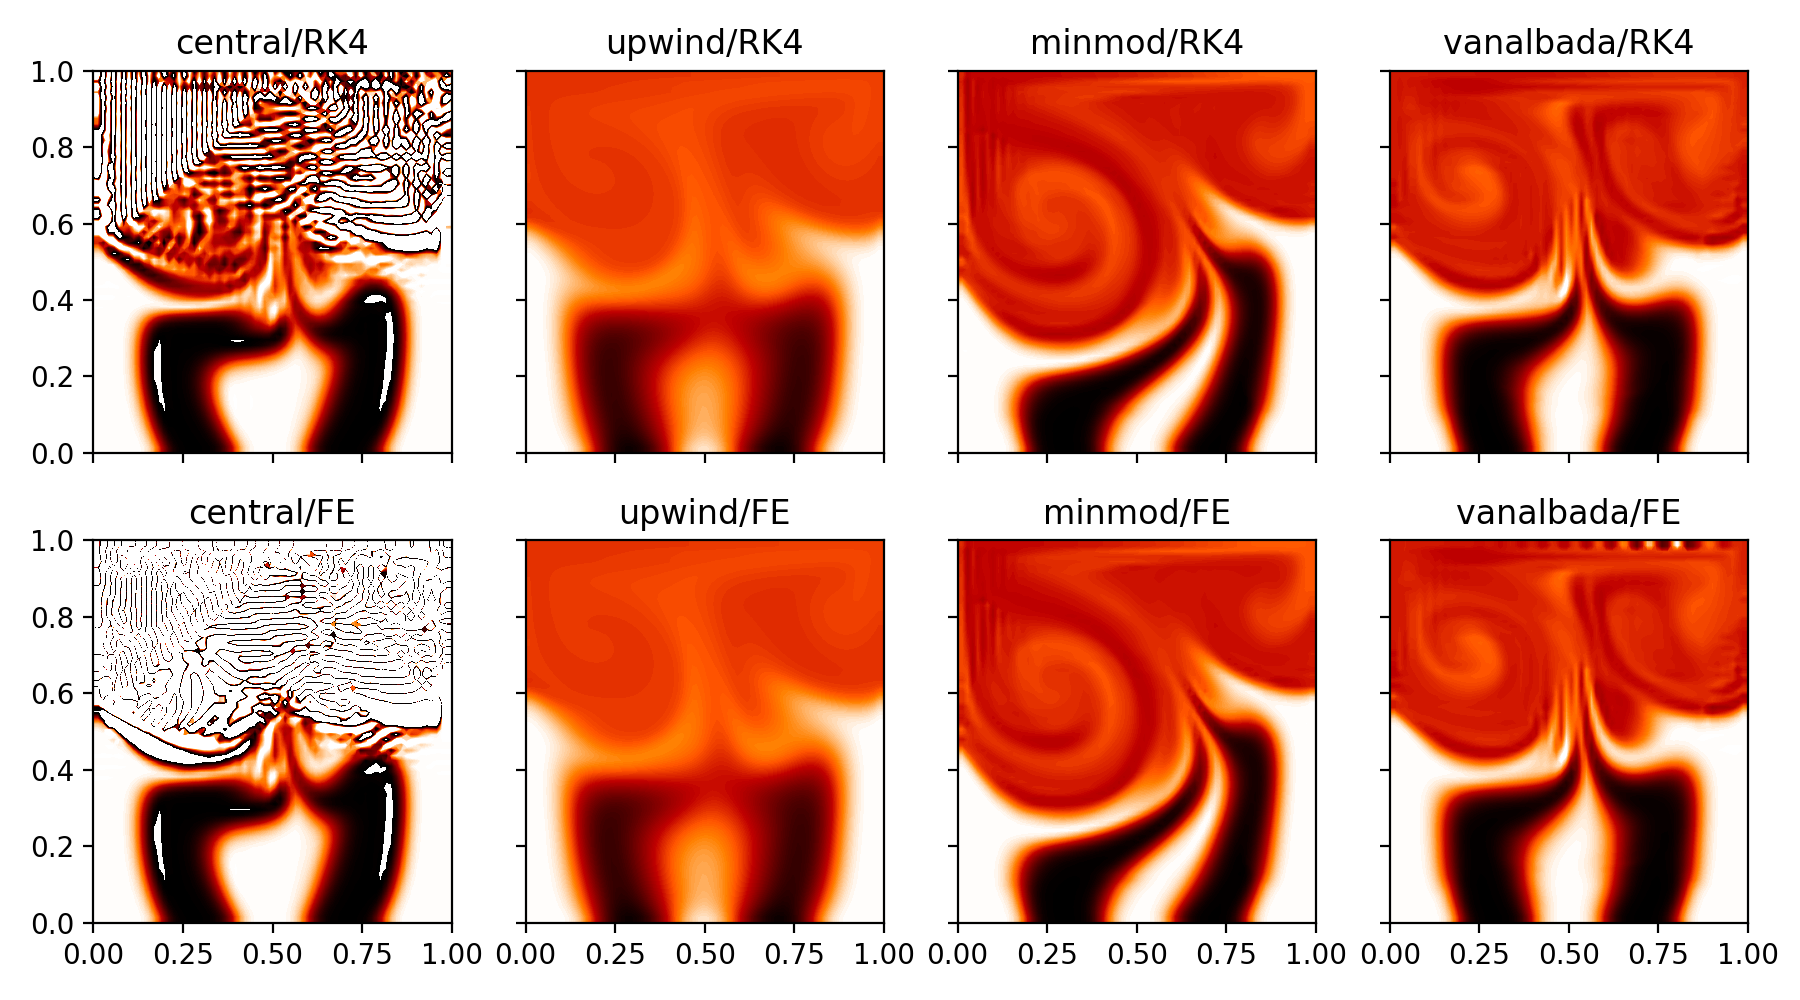

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

time_idx = -1

%matplotlib notebook

fig, axarray = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(9, 5))

for ids, scheme in enumerate(['central', 'upwind', 'minmod', 'vanalbada']):
    for idm, method in enumerate(['RK4', 'FE']):
        if (method, scheme) in sol_dict:
            axarray[idm, ids].contourf(flow_minmod.xgrid, 
                                       flow_minmod.ygrid, 
                                       sol_dict[(method, scheme)][time_idx, :, :], 
                                       levels=np.linspace(0, 1.01, 80), 
                                       cmap='gist_heat_r', 
                                       norm=Normalize(0, 1.0))
            axarray[idm, ids].set_title(f'{scheme}/{method}')
        else:
            axarray[idm, ids].set_title('n/a')
plt.tight_layout()
plt.show()

In [39]:
import matplotlib.animation as animation
import matplotlib as mpl
from matplotlib.animation import FuncAnimation

def movie(v, cmap, save_to_file=None):
    fig, ax = plt.subplots()

    ax.contourf(flow_minmod.xgrid, 
                flow_minmod.ygrid, 
                v[0, :, :], 
                levels=np.linspace(0, 1.05, 50), 
                cmap=cmap, 
                norm=Normalize(0, 1))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    def animate(i):
        ax.collections = []
        ax.cla()
        ax.contourf(flow_minmod.xgrid, 
                    flow_minmod.ygrid, 
                    v[i, :, :], 
                    levels=np.linspace(0, 1.05, 50), 
                    cmap=cmap, 
                    norm=Normalize(0, 1))
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')

    anim = FuncAnimation(fig, animate, interval=100, frames=v.shape[0])
    
    if save_to_file is not None:
        anim.save(save_to_file, dpi=1200)

    return anim

<IPython.core.display.Javascript object>


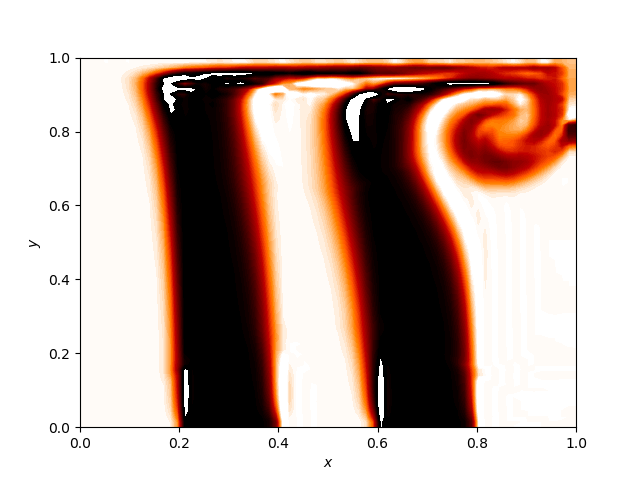

In [40]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from ipywidgets import interact, widgets

%matplotlib notebook
m = movie(sol_dict[('RK4', 'vanalbada')], 'gist_heat_r')

In [1]:
def super_movie(sol_dict, cmap, save_to_file=None):
    
    %matplotlib notebook

    fig, axarray = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(9, 5))

    def animate(i):
        for ids, scheme in enumerate(['central', 'upwind', 'minmod', 'vanalbada']):
            for idm, method in enumerate(['RK4', 'FE']):
                if (method, scheme) in sol_dict:
                    axarray[idm, ids].contourf(flow_minmod.xgrid, 
                                               flow_minmod.ygrid, 
                                               sol_dict[(method, scheme)][i, :, :], 
                                               levels=np.linspace(0, 1.01, 80), 
                                               cmap='gist_heat_r', 
                                               norm=Normalize(0, 1.0))
                    axarray[idm, ids].set_title(f'{scheme}/{method}')
                else:
                    axarray[idm, ids].set_title('n/a')

    anim = FuncAnimation(fig, animate, interval=100, frames=output_times.size)
    
    if save_to_file is not None:
        anim.save(save_to_file, dpi=1200)

    return anim

In [2]:
m = super_movie(sol_dict, 'gist_heat_r')

NameError: name 'sol_dict' is not defined

In [ ]:
# cm = 'gist_heat_r'
# 
# %matplotlib notebook
# plt.contourf(xgrid, ygrid, z_sol[:, :, 0], levels=np.linspace(0, 1.01, 64), norm=Normalize(0, 1), cmap=cm)
# plt.xlim([0, Lx])
# plt.ylim([0, Ly])
# plt.grid()
# plt.xlabel('x')
# plt.ylabel('y')
# plt.tight_layout()
# 
# def f(it):
#     plt.contourf(xgrid, ygrid, z_sol[:, :, it], levels=np.linspace(0, 1.01, 64), norm=Normalize(0, 1), cmap=cm)

# interact(f, it=widgets.IntSlider(min=0, max=ntsaved - 1, step=1, value=0));

<IPython.core.display.Javascript object>


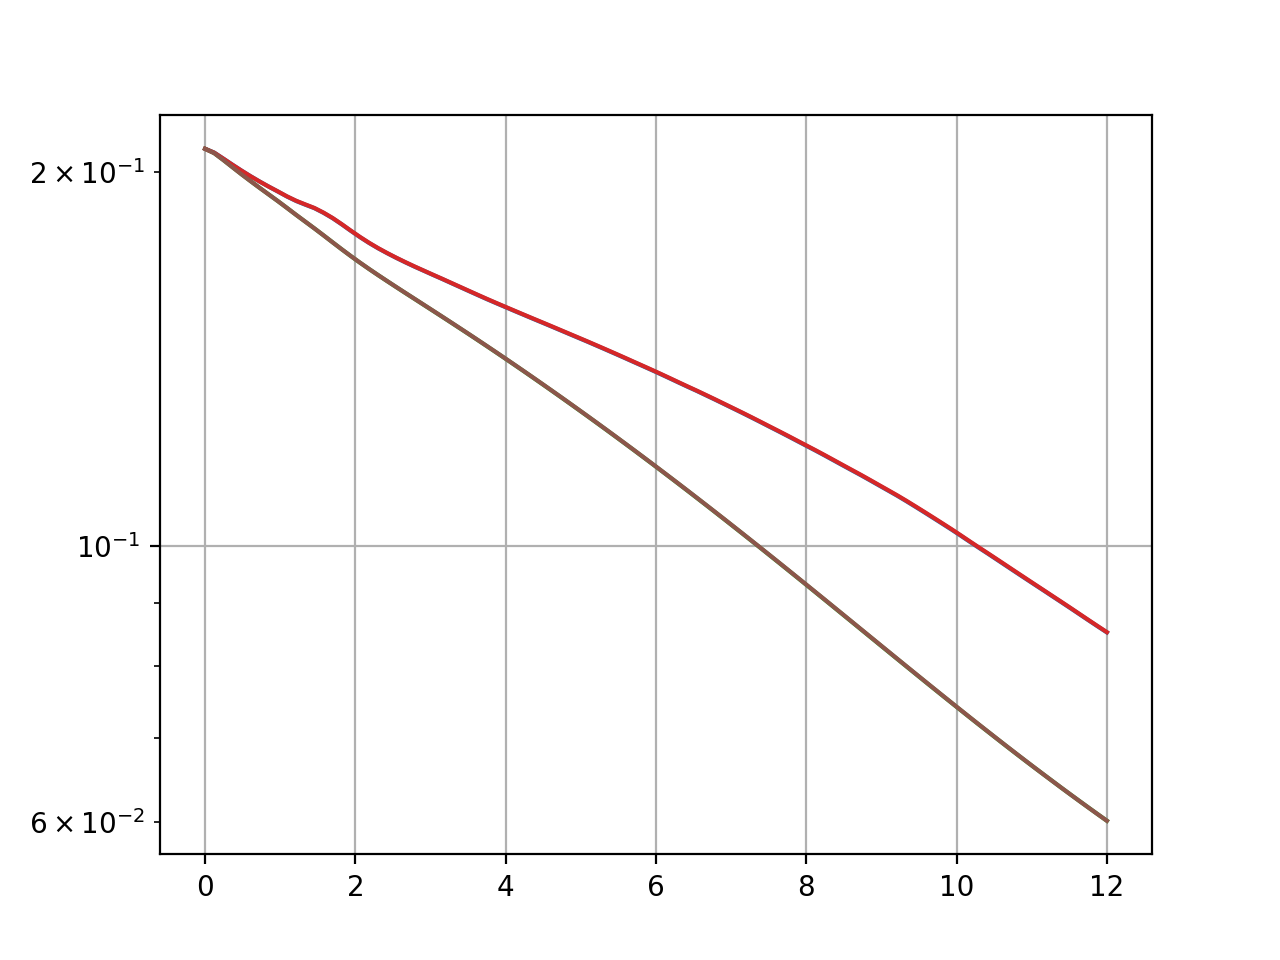

In [53]:
zvariance1 = np.zeros(output_times.size)
zvariance2 = np.zeros(output_times.size)
zvariance3 = np.zeros(output_times.size)
zvariance4 = np.zeros(output_times.size)
zvariance5 = np.zeros(output_times.size)
zvariance6 = np.zeros(output_times.size)

for i in range(output_times.size):
    zvariance1[i] = np.var(sol_dict[('RK4', 'minmod')][i, :, :].ravel())
#     zvariance2[i] = np.var(sol_dict[('RK4', 'central')][i, :, :].ravel())
    zvariance3[i] = np.var(sol_dict[('RK4', 'upwind')][i, :, :].ravel())
    zvariance4[i] = np.var(sol_dict[('FE', 'minmod')][i, :, :].ravel())
#     zvariance5[i] = np.var(sol_dict[('FE', 'central')][i, :, :].ravel())
    zvariance6[i] = np.var(sol_dict[('FE', 'upwind')][i, :, :].ravel())

%matplotlib notebook
plt.semilogy(output_times, zvariance1)
plt.semilogy(output_times, zvariance2)
plt.semilogy(output_times, zvariance3)
plt.semilogy(output_times, zvariance4)
plt.semilogy(output_times, zvariance5)
plt.semilogy(output_times, zvariance6)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


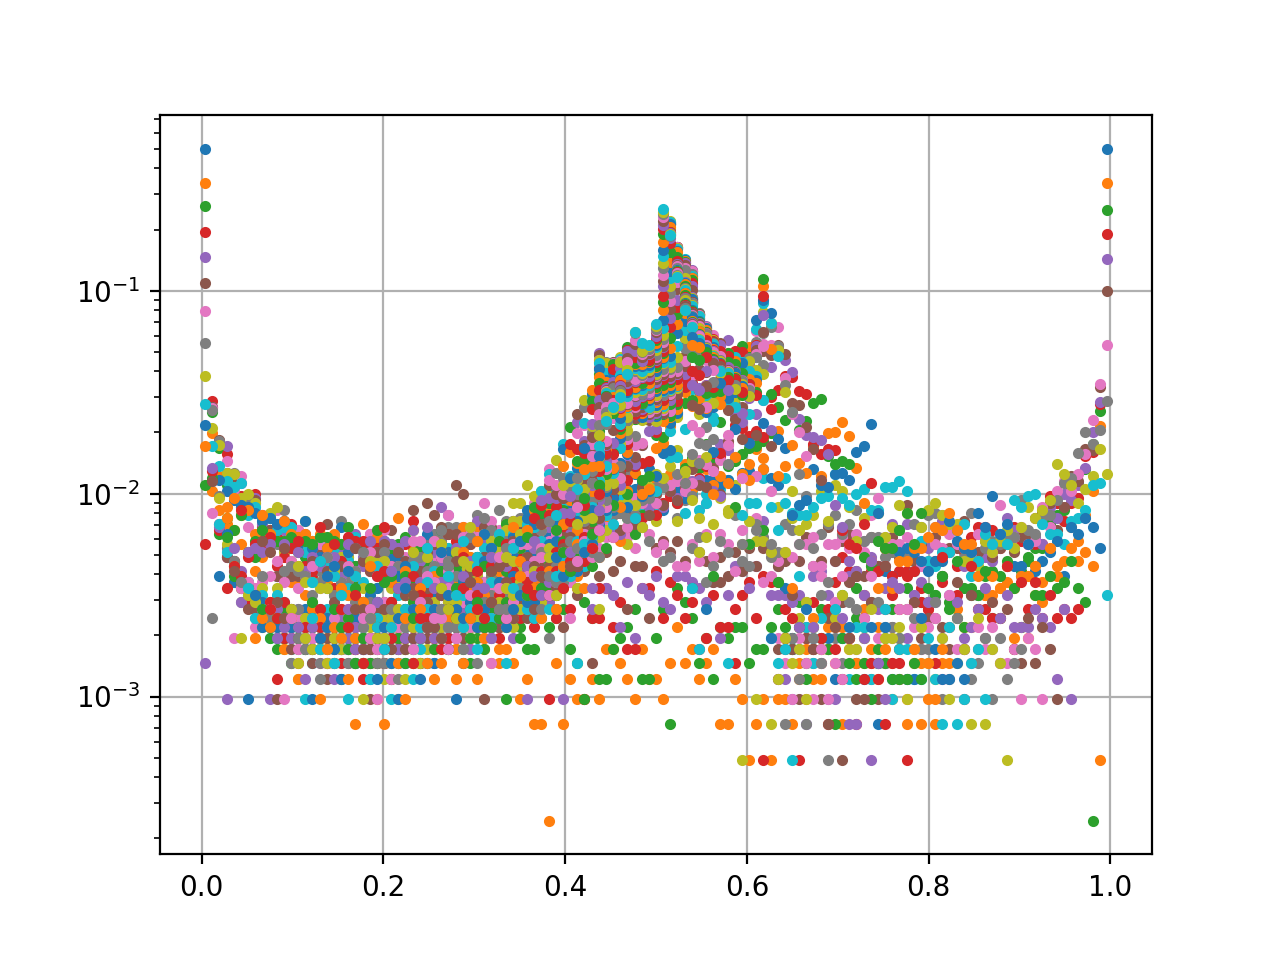

In [12]:
zpdfs = []

bins = np.linspace(0, 1, 128)
bincenters = 0.5 * (bins[1:] + bins[:-1])
for i in range(output_times.size):
    h = np.histogram(z[i, :, :].ravel(), bins=bins)
    zpdfs.append(h[0])

%matplotlib notebook

for zp in zpdfs:
    plt.plot(bincenters, zp / np.sum(zp), '.')
plt.grid()
plt.yscale('log')

<IPython.core.display.Javascript object>


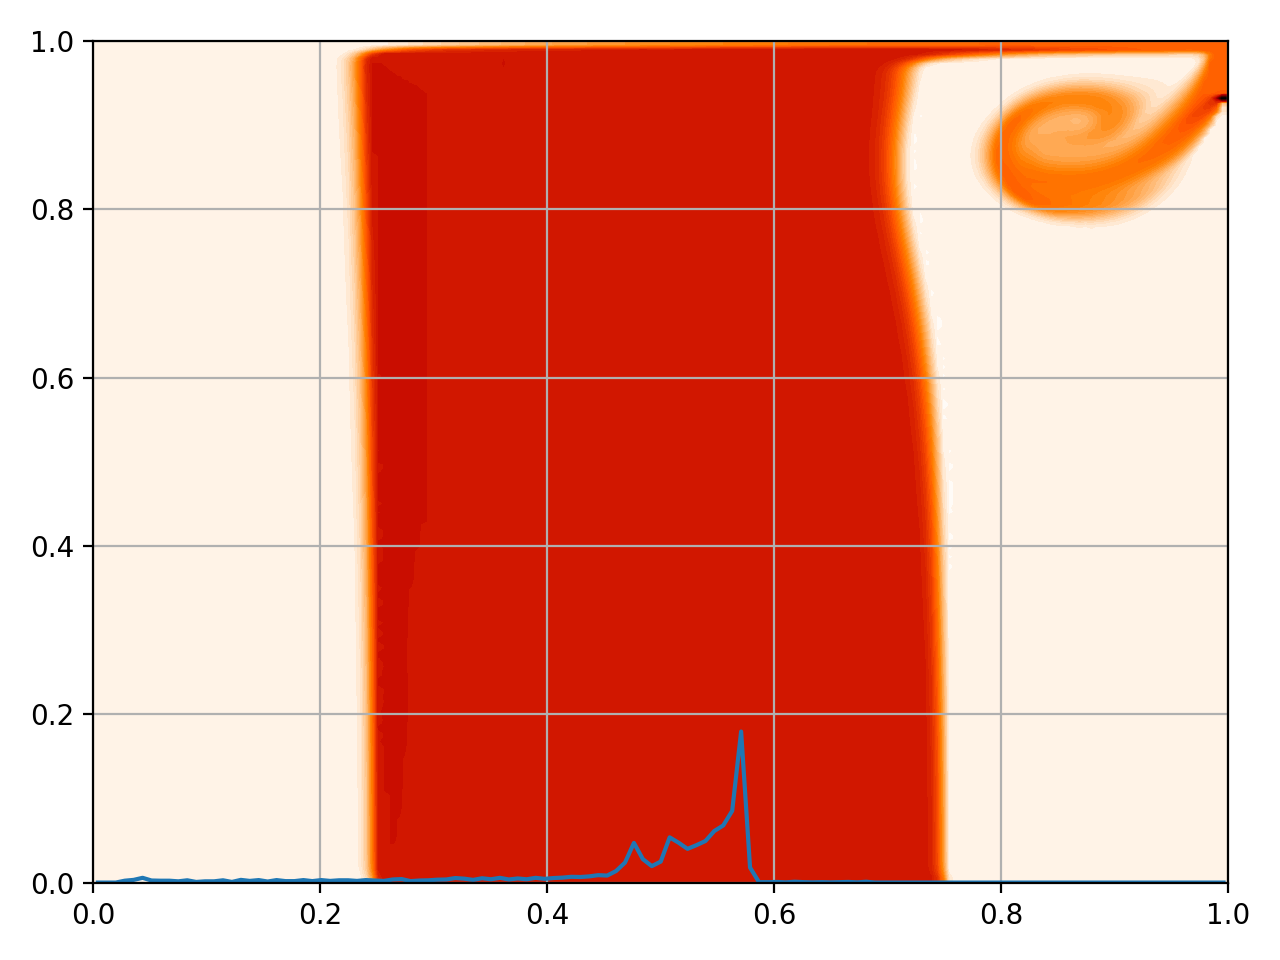

interactive(children=(IntSlider(value=0, description='it', max=99), Output()), _dom_classes=('widget-interact'…

In [14]:
%matplotlib notebook
l, = plt.plot(bincenters, zpdfs[0] / np.sum(zpdfs[0]))
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()

def f(it):
    l.set_ydata(zpdfs[it] / np.sum(zpdfs[it]))

interact(f, it=widgets.IntSlider(min=0, max=len(zpdfs) - 1, step=1, value=0));